In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.core.display import display, HTML

# stop annoying tensorflow warning messages

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [ ]:
from pathlib import PosixPath
import random
import matplotlib.pyplot as plt
%matplotlib inline 

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
root_path = '/content/drive/MyDrive/archive/training_set/training_set'
data_dir = PosixPath(root_path)

In [ ]:
image_count = len(list(data_dir.glob("*/*")))
print(f"Image count: {image_count}")

Image count: 8007


In [ ]:
class_names = os.listdir(root_path)
class_names

['cats', 'dogs']

In [ ]:
class_distribution = [len(os.listdir(root_path + '/' + name)) for name in class_names]
class_distribution

[4001, 4006]

In [ ]:
seed = random.randint(0,100)
random.seed(seed)
seed = random.randint(0,1250)
print(f"Current seed : {seed}")

Current seed : 549


(280, 300, 3)


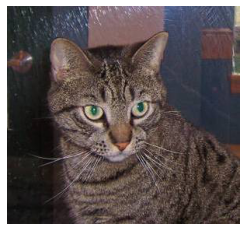

In [ ]:
img_path=r'/content/drive/MyDrive/archive/training_set/training_set/cats/cat.1.jpg'
img=plt.imread(img_path)
print (img.shape)
plt.axis('off')
plt.imshow(img)
plt.show()

In [ ]:
def preprocess (sdir, trsplit, random_seed):
    filepaths=[]
    labels=[]

    classlist=os.listdir(sdir)

    for klass in classlist:

        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)

        for f in flist:

            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)

    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)

    # split df into train_df and test_df 
    dsplit=(1-trsplit)
    strat=df['labels']    
    train_df, valid_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=random_seed, stratify=strat)
    print('train_df length: ', len(train_df), '  valid_df length: ', len(valid_df))
    return train_df, valid_df

In [ ]:
sdir=r'/content/drive/MyDrive/archive/training_set/training_set'
train_df, valid_df = preprocess(sdir, .8, seed)

train_df length:  6405   valid_df length:  1602


In [ ]:
filepaths=[]
labels=[]

classlist = os.listdir('/content/drive/MyDrive/archive/test_set/test_set')

for klass in classlist:

    classpath=os.path.join(sdir,klass)
    flist=os.listdir(classpath)

    for f in flist:

        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)

Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
test_df=pd.concat([Fseries, Lseries], axis=1)
print('test_df length: ', len(test_df))

test_df length:  8007


In [ ]:
img_size=(100,100)
channels=3
batch_size=32
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  51   test steps:  157


In [ ]:
def scalar(img):    
    return img  # EfficientNet expects pixels in range 0 to 255 so no scaling is required

trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)

train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 6403 validated image filenames belonging to 2 classes.
Found 8005 validated image filenames belonging to 2 classes.
Found 1602 validated image filenames belonging to 2 classes.


In [ ]:
class_count=len(classes)
print(class_count)

2


In [ ]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
x = Flatten()(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

best_model = ModelCheckpoint('/content/drive/MyDrive/bestmodel.hdf5', monitor='accuracy', save_best_only=True)
best_val_acc = ModelCheckpoint('/content/drive/MyDrive/best_val_acc.hdf5', monitor='val_accuracy', save_best_only=True)

In [ ]:
epochs = 3
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, batch_size = 256,  validation_data=valid_gen, callbacks=[
    best_model, best_val_acc],
    shuffle=True,  initial_epoch=0)

Epoch 1/3
201/201 [==============================] - 902s 4s/step - loss: 0.5074 - accuracy: 0.9836 - val_loss: 0.4539 - val_accuracy: 0.9557
Epoch 2/3
201/201 [==============================] - 934s 5s/step - loss: 0.3468 - accuracy: 0.9878 - val_loss: 0.3660 - val_accuracy: 0.9600
Epoch 3/3
201/201 [==============================] - 898s 4s/step - loss: 0.2863 - accuracy: 0.9875 - val_loss: 0.3089 - val_accuracy: 0.9557


In [ ]:
def visualization(name,h,color):
  t = h.history[name]
  my_max = max(t)
  my_min = min(t)
  print(f'Name : {name} max : {my_max} min : {my_min}')
  plt.plot(t,color=color,linewidth=3.0)
  plt.title(name)
  plt.ylabel(name)
  plt.xlabel('Epoch')
  plt.legend([name],loc='upper left')
  plt.show()

Name : accuracy max : 0.98781818151474 min : 0.983601450920105


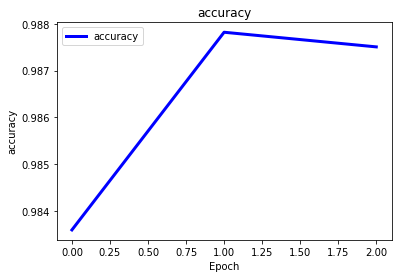

Name : loss max : 0.5073956847190857 min : 0.28625068068504333


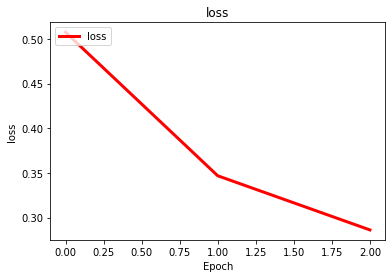

Name : val_accuracy max : 0.9600499272346497 min : 0.9556803703308105


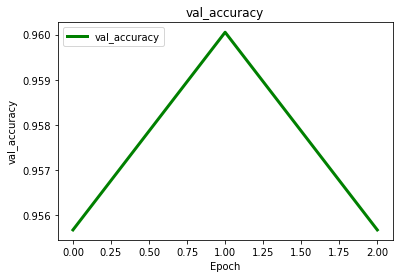

Name : val_loss max : 0.4539143145084381 min : 0.3088968098163605


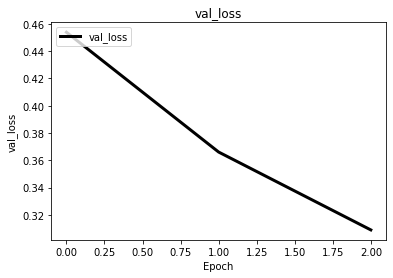

In [ ]:
visualization('accuracy',history,'Blue')
visualization('loss',history,'Red')
visualization('val_accuracy',history,'Green')
visualization('val_loss',history,'Black')

In [ ]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

model.load_weights('/content/drive/MyDrive/bestmodel.hdf5')
accuracy=model.evaluate (test_gen, steps=test_steps)[1]
print(f'accuracy on test set = {accuracy:6.2f}')

157/157 [==============================] - 216s 1s/step - loss: 0.2902 - accuracy: 0.9915
accuracy on test set =   0.99


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
predictions = model.predict_generator(test_gen, steps=test_steps)
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      4000
        dogs       0.99      0.99      0.99      4005

    accuracy                           0.99      8005
   macro avg       0.99      0.99      0.99      8005
weighted avg       0.99      0.99      0.99      8005

[[3976   24]
 [  44 3961]]


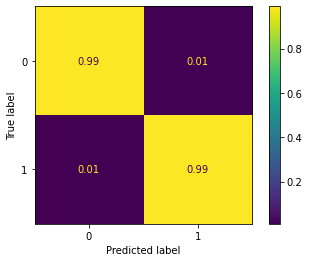

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_norm = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
cm_display = ConfusionMatrixDisplay(cm_norm)
cm_display.plot()
plt.show()

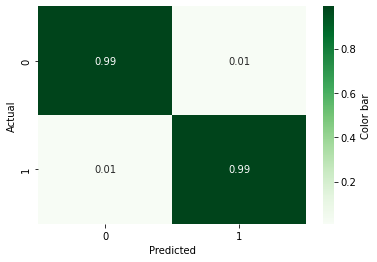

In [33]:
sns.heatmap(cm_norm,cmap='Greens',annot=True,
              cbar_kws={'orientation' : 'vertical','label' : 'Color bar'},
              fmt='.2f'
              )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
model.load_weights('/content/drive/MyDrive/best_val_acc.hdf5')
accuracy=model.evaluate (test_gen, steps=test_steps)[1]
print(f'accuracy on test set = {accuracy:6.2f}')

157/157 [==============================] - 227s 1s/step - loss: 0.2902 - accuracy: 0.9915
accuracy on test set =   0.99


In [ ]:
predictions = model.predict_generator(test_gen, steps=test_steps)
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
cm_norm = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
cm_display = ConfusionMatrixDisplay(cm_norm)
cm_display.plot()
plt.show()

In [ ]:
sns.heatmap(cm_norm,cmap='Greens',annot=True,
              cbar_kws={'orientation' : 'vertical','label' : 'Color bar'},
              fmt='.2f'
              )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)